Packages:

In [1]:
import glob
import os
import warnings


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# %pip install pydicom
import pydicom
from pydicom.data import get_testdata_files
from sklearn.model_selection import train_test_split

from IPython.display import Markdown, display

 # Import functions from the module
import importlib
import help_files._0_definitions 
import  help_files._1_visuals_script
# import  help_files._01_load_data
 # Reload the module to apply the changes to the script
importlib.reload(help_files._0_definitions)
importlib.reload(help_files._1_visuals_script)
# importlib.reload(help_files._01_load_data)
import  help_files._1_visuals_script  as pauls_vs
# Group by 'condition', 'level', and 'severity' and count occurrences
from help_files._0_definitions import count_severity_by_condition_level 
# Define the path
from pathlib import Path

pd.set_option("display.width", 1000)  # Set a large width to prevent line wrapping
 

In [2]:
### In definitions are all the functions that are used in the notebook and globals
with open("help_files/_0_definitions.py") as file:
    exec(file.read())
### In definitions are all the functions that are used in the notebook and globals
with open("help_files/_0_run_definitions.py") as file:
    exec(file.read())

In [3]:
# Specify the file names and DataFrame variable names
file_names = ["train_df_2.csv"]
# Load the data from the CSV files
dataframes = [pd.read_csv(data_path_vor / file_name) for file_name in file_names]
# Load train_df as a DataFrame
train_df = dataframes[0]
print("DataFrames have been loaded successfully.")



DataFrames have been loaded successfully.


* class MRIDataset(Dataset): and trascformation is run in _0_run_defintions.py

In [4]:
# # end sample or small sample    
if whole_data_set == True:
    print("Using the whole data set")
else:
    train_df = train_df.sample(n=20, random_state=RSEED)
    display(Markdown('<span style="color:red"> this is a small sample : 48692</span>'))

<span style="color:red"> this is a small sample : 48692</span>

set experiment name and run_id

In [5]:
# Set the experiment name (optional, helps in identifying runs)
experiment_name = "Resnet50_2_cat_basic"
# Specify the run ID of the logged model
run_id = "0eff88ff672544bdb0221d0c6415595d"  # Replace with your actual run ID

Restore parameters and metrtics from mlflow

* this only for checking previous model

In [6]:
import mlflow
# %pip install torchsummary
from torchsummary import summary
import mlflow.pytorch

# Set the experiment name (optional, helps in identifying runs)
mlflow.set_experiment(experiment_name)

# Specify the run ID of the logged model
run_id = run_id  # Replace with your actual run ID
# Create the model URI
model_uri = f"runs:/{run_id}/model"

# Load the model
model = mlflow.pytorch.load_model(model_uri)

# Now you can use the model for inference or evaluation
model.eval()  # Set the model to evaluation mode
# Get all runs for the experiment
runs = mlflow.search_runs(experiment_names=[experiment_name])

print(runs.filter(like='params.').to_string(index=False))
# Display all metrics
metrics_columns = [col for col in runs.columns if col.startswith('metrics.')]
print(runs[metrics_columns].to_string(index=False))



params.optimizer params.model_architecture params.num_epochs params.batch_size params.learning_rate params.input_size params.num_classes params.pretrained_weights params.activation_function params.num_layers
            None                      None              None              None                 None              None               None                      None                       None              None
            Adam        Modified ResNet-50                30                 4               0.0001           224x224                  2                      None                       None              None
            Adam                 ResNet-50                20                 4               0.0001           224x224                  2             IMAGENET1K_V1                       ReLU                10
            Adam                 ResNet-50                20                 4               0.0001           224x224                  2             IMAGENET1K_V1      

In [7]:
# Display the model summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Explanation of Each Column of Model

### Layer (type):
This column lists the name and type of each layer in the model. For example, `Conv2d` represents a 2D convolutional layer, `BatchNorm2d` represents a 2D batch normalization layer, `ReLU` represents a rectified linear unit activation function, and so on.

### Output Shape:
This column shows the shape of the output tensor from each layer. The shape is represented as `[-1, channels, height, width]`, where `-1` indicates a variable batch size, `channels` is the number of feature maps, and `height` and `width` are the spatial dimensions of the feature maps.

### Param #:
This column indicates the number of trainable parameters in each layer. Parameters include weights and biases that are learned during training.

## Detailed Breakdown of Some Layers

### Conv2d-1:
- **Type:** Conv2d
- **Output Shape:** `[-1, 64, 112, 112]`
- **Param #:** 9,408
- **Description:** This is the first convolutional layer with 64 filters, each of size 7x7, applied to the input image. The output feature maps have a spatial resolution of 112x112.

### BatchNorm2d-2:
- **Type:** BatchNorm2d
- **Output Shape:** `[-1, 64, 112, 112]`
- **Param #:** 128
- **Description:** This layer normalizes the output of the previous convolutional layer to improve training stability and performance.

### ReLU-3:
- **Type:** ReLU
- **Output Shape:** `[-1, 64, 112, 112]`
- **Param #:** 0
- **Description:** This layer applies the ReLU activation function, which introduces non-linearity to the model.

### MaxPool2d-4:
- **Type:** MaxPool2d
- **Output Shape:** `[-1, 64, 56, 56]`
- **Param #:** 0
- **Description:** This layer performs max pooling, reducing the spatial dimensions of the feature maps to 56x56.

### Conv2d-5:
- **Type:** Conv2d
- **Output Shape:** `[-1, 64, 56, 56]`
- **Param #:** 4,096
- **Description:** This is another convolutional layer with 64 filters, each of size 3x3, applied to the feature maps from the previous layer.

### BatchNorm2d-6:
- **Type:** BatchNorm2d
- **Output Shape:** `[-1, 64, 56, 56]`
- **Param #:** 128
- **Description:** This layer normalizes the output of the previous convolutional layer.

### ReLU-7:
- **Type:** ReLU
- **Output Shape:** `[-1, 64, 56, 56]`
- **Param #:** 0
- **Description:** This layer applies the ReLU activation function.

### Bottleneck-16:
- **Type:** Bottleneck
- **Output Shape:** `[-1, 256, 56, 56]`
- **Param #:** 0
- **Description:** This is a bottleneck block, which is a key component of ResNet architectures. It consists of multiple convolutional layers and skip connections.

#### Bottleneck-172
- **Type:** Bottleneck
- **Output Shape:** `[-1, 2048, 7, 7]`
- **Param #:** 0
- **Description:** This is a bottleneck block, which is a key component of ResNet architectures. It consists of multiple convolutional layers and skip connections.

#### AdaptiveAvgPool2d-173
- **Type:** AdaptiveAvgPool2d
- **Output Shape:** `[-1, 2048, 1, 1]`
- **Param #:** 0
- **Description:** This layer performs adaptive average pooling, reducing the spatial dimensions of the feature maps to 1x1 while maintaining the number of channels.

#### Linear-174
- **Type:** Linear
- **Output Shape:** `[-1, 3]`
- **Param #:** 6,147
- **Description:** This is a fully connected (dense) layer with 3 output units, typically used for classification tasks. The number of parameters includes the weights and biases.

## Summary of the Model

- **Total Parameters:** 23,514,179
- **Trainable Parameters:** 23,514,179
- **Non-trainable Parameters:** 0
- **Input Size (MB):** 0.57
- **Forward/Backward Pass Size (MB):** 286.55
- **Params Size (MB):** 89.70
- **Estimated Total Size (MB):** 376.82

## Explanation of the Summary

- **Total Parameters:** The total number of parameters in the model, including both trainable and non-trainable parameters.
- **Trainable Parameters:** The number of parameters that are updated during training.
- **Non-trainable Parameters:** The number of parameters that are not updated during training (e.g., fixed weights).
- **Input Size (MB):** The memory size of the input data.
- **Forward/Backward Pass Size (MB):** The memory size required for the forward and backward passes during training.
- **Params Size (MB):** The memory size of the model parameters.
- **Estimated Total Size (MB):** The estimated total memory size required for the model.

This detailed breakdown helps in understanding the architecture and complexity of the ResNet-like model, including the number of layers, their types, output shapes, and the number of parameters.

Transforming pretrained model: freezing layers and i# Set the model to evaluation mode
model.eval()ntroduce addtional ones

Ttrasformaiton and dataloader (do not change over models)

In [8]:
# define transformation and class
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
# %pip install torch torchvision
import torchvision.models as models
from torchvision import transforms
import pydicom
# %pip install opencv-python
import cv2
import pandas as pd

### In definitions are all the functions that are used in the notebook and globals
with open("help_files/_0_run_definitions.py") as file:
    exec(file.read())


* import parameers (weights) from previous model

In [9]:
import mlflow
import mlflow.pytorch
import random

# Set random seed for reproducibility
seed = 42  # You can choose any integer
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Set up the experiment in MLflow
mlflow.set_experiment(experiment_name)

# Specify the run ID and load the model from MLflow
run_id = run_id # Replace with your actual run ID
model_uri = f"runs:/{run_id}/model"

# Load the model
m_1 = mlflow.pytorch.load_model(model_uri)

# Verify the model is loaded correctly
print("Loaded Model:")
print(m_1)

Loaded Model:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1

Freezing layer and defining new one 

In [10]:
# Move the model to the appropriate device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
m_1.to(device)

# Freeze all layers of the loaded model
for param in m_1.parameters():
    param.requires_grad = False  # Freeze all parameters

# Modify the fully connected (fc) layer to match new requirements
m_1.fc = nn.Sequential(
    nn.Linear(m_1.fc.in_features, 512),  # Intermediate fully connected layer to last RsNet50 layer
    nn.ReLU(),                           # Activation function
    nn.Dropout(0.5),                     # 50 percent are  dropout
    nn.Linear(512, train_df['severity'].nunique())  # Final layer for classification
)

# Move the modified model to the appropriate device (GPU or CPU) again, in case of changes
m_1.to(device)

# Set up training dataset and DataLoaders  
dataset = MRIDataset(data=train_df, transform=transform)



In [11]:
train_data = train_df

* some settings: train validation,  Early stopping parameters

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models
# %pip install keras
# %pip install tensorflow
# from tensorflow.keras.callbacks import EarlyStopping  # Import EarlyStopping
import numpy as np  # Import numpy for setting the random seed

# Create the dataset
dataset = MRIDataset(data=train_data, transform=transform)

# Split the dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Define loss functions and optimizer
criterion_cel = nn.CrossEntropyLoss()
optimizer = optim.Adam(m_1.parameters(), lr=0.0001)
num_epochs = 30

# Lists to store loss values for plotting
train_losses_cel = []
val_losses_cel = []

# Early stopping parameters
stop_threshold = 0.2  # Threshold for validation loss to diverge from training loss
diverge_count = 0
max_diverge_count = 3  # Number of epochs validation loss is allowed to diverge



* setting mlflow: end running new model

In [13]:
# Start MLflow run
with mlflow.start_run(nested=True):
    # Log parameters
    mlflow.log_param("learning_rate", 0.0001)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("batch_size", 4)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("model_architecture", "Modified ResNet-50")
    mlflow.log_param("input_size", "224x224")
    mlflow.log_param("num_classes", train_df['severity'].nunique())

    # Training and validation loop
    for epoch in range(num_epochs):
        # Training phase
        m_1.train()
        running_loss_cel_train = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = m_1(images)
            
            # Cross Entropy Loss
            loss_cel = criterion_cel(outputs, labels)
            running_loss_cel_train += loss_cel.item()
            
            # Backward pass and optimization
            loss_cel.backward()
            optimizer.step()

        # Calculate average losses
        epoch_loss_cel_train = running_loss_cel_train / len(train_loader)
        train_losses_cel.append(epoch_loss_cel_train)

        # Log training losses to MLflow
        mlflow.log_metric("train_loss_cel", epoch_loss_cel_train, step=epoch)

        # Validation phase
        m_1.eval()
        running_loss_cel_val = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = m_1(images)
                
                # Cross Entropy Loss for validation
                loss_cel = criterion_cel(outputs, labels)
                running_loss_cel_val += loss_cel.item()

        # Calculate validation losses
        epoch_loss_cel_val = running_loss_cel_val / len(val_loader)
        val_losses_cel.append(epoch_loss_cel_val)


        # Log validation losses to MLflow
        mlflow.log_metric("val_loss_cel", epoch_loss_cel_val, step=epoch)

        best_val_loss = float('inf')
        patience, patience_counter = 5, 0  # for example, wait for 5 epochs with no improvement

        # pausls Set parameters for both early stopping methods sonst nimm die alte verison
        stop_threshold = 0.1           # Threshold for divergence
        max_diverge_count = 3          # Max number of epochs with diverging validation loss
        patience = 5                   # Number of epochs for validation loss plateau
        best_val_loss = float('inf')   # Initialize best validation loss
        diverge_count = 0              # Counter for divergence-based stopping
        patience_counter = 0           # Counter for plateau-based stopping     

        for epoch in range(num_epochs):
            # Training and validation steps
            # Assume epoch_loss_cel_train and epoch_loss_cel_val are calculated after each epoch        

            # Check divergence-based stopping
            if epoch_loss_cel_val > epoch_loss_cel_train * (1 + stop_threshold):
                diverge_count += 1
                if diverge_count >= max_diverge_count:
                    print(f"Early stopping at epoch {epoch+1} due to validation loss diverging.")
                    break
            else:
                diverge_count = 0  # Reset diverge count if validation loss is not diverging        

            # Check plateau-based stopping
            if epoch_loss_cel_val < best_val_loss:
                best_val_loss = epoch_loss_cel_val
                patience_counter = 0  # Reset plateau counter if validation loss improves
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1} due to lack of validation loss improvement.")
                    break
            # Print epoch results
            print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Cross Entropy Loss: {epoch_loss_cel_train:.4f}, '
              f'Validation Cross Entropy Loss: {epoch_loss_cel_val:.4f}')

    print("Training complete!")


    # Log the model
    mlflow.pytorch.log_model(m_1, "modified_model")

    # passing to mlflow
   # Plot and log the loss curves as artifacts a
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_cel, label='Train Cross Entropy Loss')
    plt.plot(val_losses_cel, label='Validation Cross Entropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Cross Entropy Loss')
    plt.legend()
    plt.savefig("cross_entropy_loss.png")
    mlflow.log_artifact("cross_entropy_loss.png")



Epoch [1/30], Train Cross Entropy Loss: 0.6309, Validation Cross Entropy Loss: 0.2975
Epoch [2/30], Train Cross Entropy Loss: 0.6309, Validation Cross Entropy Loss: 0.2975
Epoch [3/30], Train Cross Entropy Loss: 0.6309, Validation Cross Entropy Loss: 0.2975
Epoch [4/30], Train Cross Entropy Loss: 0.6309, Validation Cross Entropy Loss: 0.2975
Epoch [5/30], Train Cross Entropy Loss: 0.6309, Validation Cross Entropy Loss: 0.2975
Early stopping at epoch 6 due to lack of validation loss improvement.
Epoch [1/30], Train Cross Entropy Loss: 0.3913, Validation Cross Entropy Loss: 0.1556
Epoch [2/30], Train Cross Entropy Loss: 0.3913, Validation Cross Entropy Loss: 0.1556
Epoch [3/30], Train Cross Entropy Loss: 0.3913, Validation Cross Entropy Loss: 0.1556
Epoch [4/30], Train Cross Entropy Loss: 0.3913, Validation Cross Entropy Loss: 0.1556
Epoch [5/30], Train Cross Entropy Loss: 0.3913, Validation Cross Entropy Loss: 0.1556
Early stopping at epoch 6 due to lack of validation loss improvement.


KeyboardInterrupt: 

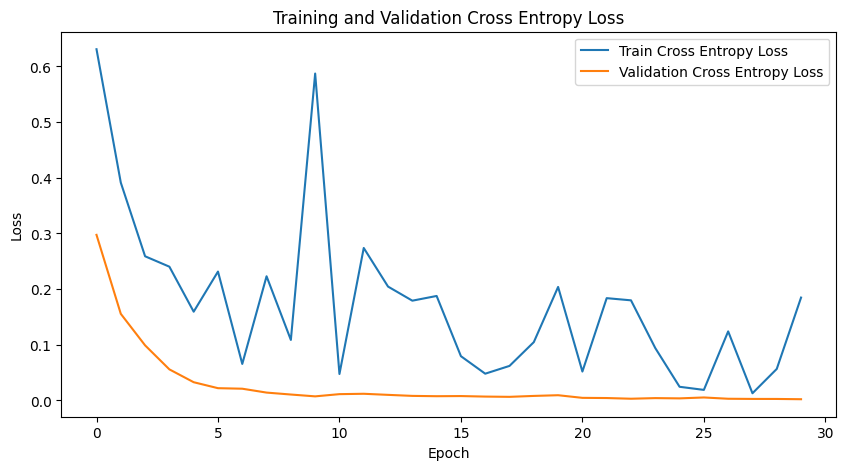

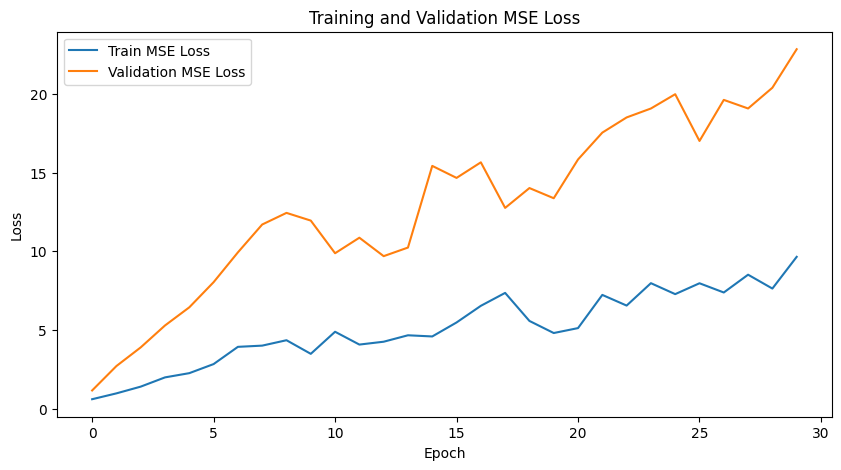

In [70]:
# Plot and log the loss curves as artifacts
plt.figure(figsize=(10, 5))
plt.plot(train_losses_cel, label='Train Cross Entropy Loss')
plt.plot(val_losses_cel, label='Validation Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Cross Entropy Loss')
plt.legend()
plt.savefig("cross_entropy_loss.png")
mlflow.log_artifact("cross_entropy_loss.png")


In [71]:
# Count how many layers are frozen
frozen_layers_count = sum(1 for param in m_1.parameters() if not param.requires_grad)

# Get total number of layers (parameters)
total_layers_count = sum(1 for _ in m_1.parameters())

print(f"Frozen layers: {frozen_layers_count}/{total_layers_count} ({(frozen_layers_count / total_layers_count) * 100:.2f}%)")


Frozen layers: 159/163 (97.55%)


In [72]:
# Print the status of each layer
for name, param in m_1.named_parameters():
    if not param.requires_grad:
        print(f"Layer '{name}' is frozen.")
    else:
        print(f"Layer '{name}' is trainable.")

Layer 'conv1.weight' is frozen.
Layer 'bn1.weight' is frozen.
Layer 'bn1.bias' is frozen.
Layer 'layer1.0.conv1.weight' is frozen.
Layer 'layer1.0.bn1.weight' is frozen.
Layer 'layer1.0.bn1.bias' is frozen.
Layer 'layer1.0.conv2.weight' is frozen.
Layer 'layer1.0.bn2.weight' is frozen.
Layer 'layer1.0.bn2.bias' is frozen.
Layer 'layer1.0.conv3.weight' is frozen.
Layer 'layer1.0.bn3.weight' is frozen.
Layer 'layer1.0.bn3.bias' is frozen.
Layer 'layer1.0.downsample.0.weight' is frozen.
Layer 'layer1.0.downsample.1.weight' is frozen.
Layer 'layer1.0.downsample.1.bias' is frozen.
Layer 'layer1.1.conv1.weight' is frozen.
Layer 'layer1.1.bn1.weight' is frozen.
Layer 'layer1.1.bn1.bias' is frozen.
Layer 'layer1.1.conv2.weight' is frozen.
Layer 'layer1.1.bn2.weight' is frozen.
Layer 'layer1.1.bn2.bias' is frozen.
Layer 'layer1.1.conv3.weight' is frozen.
Layer 'layer1.1.bn3.weight' is frozen.
Layer 'layer1.1.bn3.bias' is frozen.
Layer 'layer1.2.conv1.weight' is frozen.
Layer 'layer1.2.bn1.weigh